In [1]:
%%bash

pip install getgist
getgist lambdaofgod github_topic_modeling_packages.sh
bash github_topic_modeling_packages.sh

  Fetching https://api.github.com/users/lambdaofgod/gists
  Reading https://gist.githubusercontent.com/lambdaofgod/c32ab43cecce4219a697376f3dda3866/raw/689cf570db88e3a951821624fd652c2342efa755/github_topic_modeling_packages.sh
Overwrite existing github_topic_modeling_packages.sh? (y/n)  [y/N]: Error: invalid input
Overwrite existing github_topic_modeling_packages.sh? (y/n)  [y/N]: 

pynvim 0.3.2 requires greenlet, which is not installed.
pynvim 0.3.2 requires msgpack>=0.5.0, which is not installed.
mkl-random 1.0.1 requires cython, which is not installed.
mkl-fft 1.0.0 requires cython, which is not installed.
tensorboard 1.8.0 has requirement markdown>=2.6.8, but you'll have markdown 2.4.1 which is incompatible.
mxnet 1.2.0 has requirement numpy<1.15.0,>=1.8.2, but you'll have numpy 1.15.0 which is incompatible.
You are using pip version 10.0.1, however version 19.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Aborted!


In [2]:
import os

import re
import tqdm
import requests

import numpy as np

from bs4 import BeautifulSoup
from markdown import markdown


import pandas as pd
from pandas.io.json import json_normalize
from gensim import summarization

from sklearn import decomposition, feature_extraction, manifold
from sklearn.feature_extraction import stop_words
from sklearn import pipeline
 

from mlutil import topic_modeling

import seaborn as sns
import wordcloud

import matplotlib.pyplot as plt
from IPython.display import Markdown, display

import github3

/home/kuba/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
plt.style.use('dark_background')

In [4]:
def printmd(string):
    display(Markdown(string))

In [5]:
if os.path.exists('github_auth_key.txt'):
    token = open('github_auth_key.txt').read().rstrip()
    headers = {'Authorization': 'token %s' % token}
else:
    token = ''
    headers = {}

In [6]:
def search_repositories(query, pages=10):
    i = 1
    url = 'https://api.github.com/search/repositories?q={}&page={}&per_page=100'
    starred_response = []
    tmp_response = requests.get(url.format(query, i), headers={**headers, "Accept": "application/vnd.github.mercy-preview+json"})
    while tmp_response.ok and i <= pages:
        starred_response = starred_response + tmp_response.json()['items']
        i += 1
        tmp_response = requests.get(url.format(query, i), headers={**headers, "Accept": "application/vnd.github.mercy-preview+json"})

    print(tmp_response.json())
    if len(starred_response) == 0:
        raise requests.HTTPError('Error occured while fetching, most likely you went over rate limit')
    else:
        return starred_response

In [7]:
def get_cleaned_repositories_df(repo_information):
    repo_df = json_normalize(repo_information)
    repo_df = repo_df.drop_duplicates(subset=['name'])
    repo_df.index = repo_df['name']
    repo_df.drop('name', axis=1, inplace=True)
    repo_df['topics'] = repo_df['topics'].apply(' '.join)
    repo_df['description'] = repo_df['description'].fillna('')
    return repo_df


def get_word_cloud(texts):
    text = ' '.join(texts)
    return wordcloud.WordCloud(max_font_size=40).generate(text)


def show_word_cloud(wc, figure_kwargs={'figsize': (8, 5)}):
    plt.figure(**figure_kwargs)
    plt.imshow(wc)
    plt.axis('off')
    plt.show()

  
def show_word_cloud_from_texts(text_column):
    texts = text_column.fillna('').values
    cloud = get_word_cloud(texts)
    show_word_cloud(cloud)


def get_topic_representant_indices(topic_weights, topic_idx, num_representants=5):
    indices = topic_weights[:, topic_idx].argsort()[::-1]
    return indices[:num_representants]


def get_repos_representing_topic(repo_df, topic_weights, topic_idx, num_representants=5):
    return repo_df.iloc[get_topic_representant_indices(topic_weights, topic_idx, num_representants)]

In [8]:
topics = ['machine-learning', 'nlp', 'text-mining']

In [9]:
%%time
ml_repos = search_repositories('topic:machine-learning')

{'message': 'Only the first 1000 search results are available', 'documentation_url': 'https://developer.github.com/v3/search/'}
CPU times: user 504 ms, sys: 32 ms, total: 537 ms
Wall time: 25 s


In [10]:
len(ml_repos)

1000

In [11]:
%%time
tm_repos = search_repositories('topic:text-mining')

{'message': 'Only the first 1000 search results are available', 'documentation_url': 'https://developer.github.com/v3/search/'}
CPU times: user 481 ms, sys: 18.2 ms, total: 500 ms
Wall time: 21.7 s


In [12]:
len(tm_repos)

870

In [13]:
%%time
nlp_repos = search_repositories('topic:nlp')

{'message': 'Only the first 1000 search results are available', 'documentation_url': 'https://developer.github.com/v3/search/'}
CPU times: user 529 ms, sys: 25.6 ms, total: 555 ms
Wall time: 24.7 s


In [14]:
len(nlp_repos)

1000

In [15]:
repo_df = get_cleaned_repositories_df(ml_repos + nlp_repos + tm_repos)

In [16]:
repo_df['description_keywords'] = repo_df['description'].apply(summarization.keywords)

Primary language

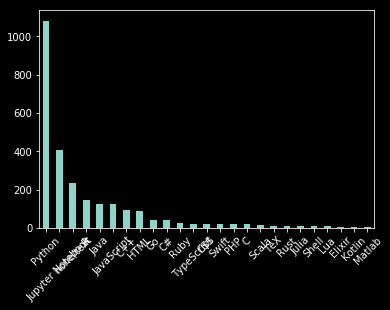

In [17]:
repo_df['language'].fillna('none/text').value_counts()[:25].plot.bar(rot=45);

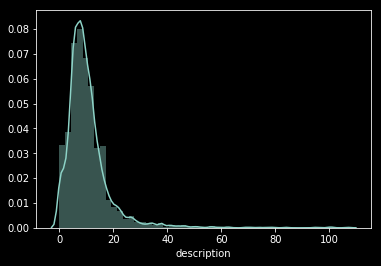

In [18]:
sns.distplot(repo_df['description'].str.split().apply(lambda l: 0 if l is None else len(l)));

Topics word cloud

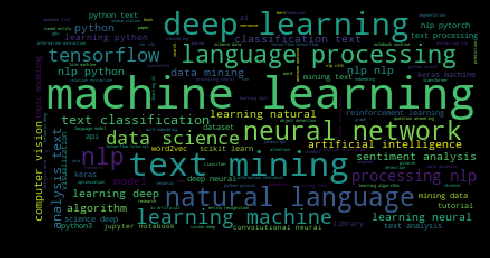

In [19]:
show_word_cloud_from_texts(repo_df['topics'])

Descriptions word cloud

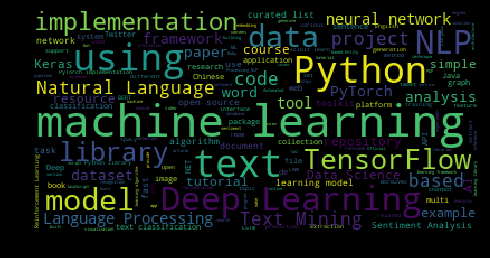

In [20]:
show_word_cloud_from_texts(repo_df['description'])

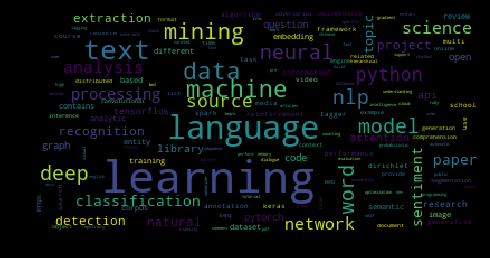

In [21]:
show_word_cloud_from_texts(repo_df['description_keywords'])

## Topic modeling (repo descriptions)

In [22]:
num_topics = 10

topic_modeler = decomposition.NMF(n_components=num_topics)

In [23]:
deduped_repo_df = repo_df.drop_duplicates()

In [24]:
vectorizer = feature_extraction.text.TfidfVectorizer(
    stop_words=stop_words.ENGLISH_STOP_WORDS,
    ngram_range=(1,1)
)
description_vectors = vectorizer.fit_transform(repo_df['description'])

In [25]:
reduced_description_vectors = topic_modeler.fit_transform(description_vectors)

In [26]:
topic_words = topic_modeling.top_topic_words(topic_modeler, vectorizer.get_feature_names(), 10)

In [27]:
top_words_per_topic = [list(topic_words.iloc[topic].values) for topic in range(num_topics)]
representative_repos = [get_repos_representing_topic(repo_df, reduced_description_vectors, topic)[['description']] for topic in range(num_topics)]

## Topic keywords and most representative repositories

In [28]:
for topic in range(num_topics):
    printmd('## **topic {} keywords:**'.format(topic + 1))
    display(top_words_per_topic[topic])
    printmd('## **repositories representative for {}th topic:**'.format(topic + 1))
    display(representative_repos[topic])
    print()

## **topic 1 keywords:**

['learning',
 'machine',
 'deep',
 'reinforcement',
 'framework',
 'models',
 'open',
 'library',
 'toolkit',
 'algorithms']

## **repositories representative for 1th topic:**

,description
name,
ConvNetSharp,Deep Learning in C#
OpenML,Open Machine Learning
Machine-Learning-Tutorials,"machine learning and deep learning tutorials, ..."
1-Year-ML-Journey,An advanced program in Machine Learning and De...
Repo-2017,"Python codes in Machine Learning, NLP, Deep Le..."


## **topic 2 keywords:**

['text',
 'mining',
 'classification',
 'project',
 'based',
 'short',
 'using',
 'information',
 'shiny',
 'web']

## **repositories representative for 2th topic:**

,description
name,
text-mining,Text Mining in Python
twitter,Python text mining
text-mining-tutorial,NLP for text mining
Twitter-Sentiment-Analysis-using-R-shiny,Project based on text mining:
Twitter-Sentiment-IPhoneXSMAX,Sentiment Analysis | Text Mining


## **topic 3 keywords:**

['language',
 'natural',
 'processing',
 'detection',
 'library',
 'parser',
 'art',
 'state',
 'toolkit',
 'php']

## **repositories representative for 3th topic:**

,description
name,
MUSA-620-Week-9,Text mining / natural language processing
NLP-Papers,Natural Language Processing Papers
deep-NLP,from kaggle natural language processing
nuve,Natural Language Processing Library for Turkis...
franc,Natural language detection


## **topic 4 keywords:**

['neural',
 'network',
 'implementation',
 'pytorch',
 'networks',
 'classification',
 'convolutional',
 'based',
 'keras',
 'model']

## **repositories representative for 4th topic:**

,description
name,
character-based-cnn,Implementation of character based convolutiona...
VDCNN,Tensorflow and Keras Implementation of Very De...
CNN-text-classification-keras,Text Classification by Convolutional Neural Ne...
deepvoice3_pytorch,PyTorch implementation of convolutional neural...
MeshCNN,Convolutional Neural Network for 3D meshes in ...


## **topic 5 keywords:**

['data',
 'science',
 'code',
 'project',
 'repository',
 'visualization',
 'projects',
 'mining',
 'course',
 'big']

## **repositories representative for 5th topic:**

,description
name,
Data-Science-,For the data science/data analysis
Text-classification-sarcastic-or-not,Text mining and Data Science applications on t...
Data-Science-R-Python,Basic data science approaches to deal with the...
ConText,constructing network data from text data
Text-Mining-of-Qidian-Website,This is a final project of Data Mining course ...


## **topic 6 keywords:**

['python',
 'library',
 'learn',
 'scikit',
 'api',
 'package',
 'wrapper',
 'using',
 'algorithm',
 'nltk']

## **repositories representative for 6th topic:**

,description
name,
twitter,Python text mining
text-mining,Text Mining in Python
experiments_with_python,experiments with python
text_classifier,Text Classification in Python and in R
pyphonetics,A Python 3 phonetics library.


## **topic 7 keywords:**

['nlp',
 'spacy',
 'course',
 'deep',
 'models',
 'library',
 'open',
 'research',
 'oxford',
 'source']

## **repositories representative for 7th topic:**

,description
name,
textacy,"NLP, before and after spaCy"
DeepNLP-Course,Deep NLP Course
overview-and-benchmark-of-traditional-and-deep-learning-models-in-text-classification,NLP tutorial
gluon-nlp,NLP made easy
text-mining-tutorial,NLP for text mining


## **topic 8 keywords:**

['list',
 'curated',
 'resources',
 'awesome',
 'papers',
 'tutorials',
 'ai',
 'science',
 'libraries',
 'research']

## **repositories representative for 8th topic:**

,description
name,
Awesome-Distributed-Deep-Learning,A curated list of awesome Distributed Deep Lea...
machine-learning-with-ruby,Curated list: Resources for machine learning i...
awesome-machine-learning-interpretability,A curated list of awesome machine learning int...
awesome-anomaly-detection,A curated list of awesome anomaly detection re...
awesome-hungarian-nlp,A curated list of NLP resources for Hungarian


## **topic 9 keywords:**

['tensorflow',
 'implementation',
 'net',
 'keras',
 'models',
 'using',
 'tutorials',
 'deep',
 'api',
 'implemented']

## **repositories representative for 9th topic:**

,description
name,
R-Net,Tensorflow Implementation of R-Net
R-NET-in-Tensorflow,R-NET implementation in TensorFlow.
tfpyth,"Putting TensorFlow back in PyTorch, back in Te..."
learning-to-learn,Learning to Learn in TensorFlow
tefla,Tensorflow deep-learning framework


## **topic 10 keywords:**

['analysis',
 'sentiment',
 'using',
 'twitter',
 'word2vec',
 'tweets',
 'reviews',
 'topic',
 'word',
 'package']

## **repositories representative for 10th topic:**

,description
name,
SentimentAnalysis-Word2Vec,Sentiment Analysis using Word2Vec
Twitter-Sentiment-IPhoneXSMAX,Sentiment Analysis | Text Mining
Sentiment-Analysis-Twitter-Data,In this Repository I have attached the file fo...
sentweetment,A personal project on sentiment analysis
sentR,Robust sentiment analysis package for R
